## Import Libraries

In [54]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime

## Connect to Database

In [55]:
host='localhost'
port='5433'
db='HealthDB'
schema='HealthSurvey'
user='postgres'
pswd='Scootmo24!'
conn_string = 'postgresql+psycopg2://'+user+':'+pswd+'@'+host+':'+port+'/'+db

eng = create_engine(conn_string)
conn = eng.connect()  

# Set the Schema
query = 'SET search_path TO \"HealthSurvey\"'
rs=conn.execute(query)

Exception during reset or similar
Traceback (most recent call last):
  File "C:\Users\timbr\Anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 739, in _finalize_fairy
    fairy._reset(pool)
  File "C:\Users\timbr\Anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 988, in _reset
    pool._dialect.do_rollback(self)
  File "C:\Users\timbr\Anaconda3\lib\site-packages\sqlalchemy\engine\default.py", line 682, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.



## Load Data

In [56]:
before = datetime.now()
df = pd.read_sql("select * from model_chd", conn)
after = datetime.now()

print('rows=',len(df),'start=',before,'end',after)


rows= 438693 start= 2022-12-20 15:42:26.136115 end 2022-12-20 15:42:58.769505


In [58]:
print('Total Columns:',len(df.columns))
for col in df:
    print(col)

Total Columns: 62
dem_age__age_g_cat
dem_numchildeninhouse__chldcnt_cat
dem_sex__sex_cat
dem_geographic__metstat_cat
dem_geographic__urbstat_cat
dem_language_qstlang_cat
dem_maritalstatus_marital_cat
dem_state__imprace_cat
dem_state__state_cat
gh_healthstatus__rfhlth_cat
gh_careprovider_persdoc3_bin
gh_excercise__totinda_bin
gh_excercise_exerany2_bin
gh_bmi__bmi5cat_cat
gh_height_htin4_cont
gh_routinecheckup_checkup1_cat
gh_status__phys14d_cat
gh_status_genhlth_cat
gh_weight_wtkg3_cont
hc_arthritis__drdxar3_cat
hc_asthma__casthm1_bin
hc_cancer_chcocncr_bin
hc_chd__michd_cat
hc_cvd__cholch3_cat
hc_cvd__rfchol3_bin
hc_cvd__rfhype6_bin
hc_cvd_cholchk3_cat
hc_cvd_cholmed3_bin
hc_cvd_cvdstrk3_bin
hc_diabetes_diabete4_cat
hc_hearing_deaf_bin
hc_hiv__aidtst4_bin
hc_kidney_chckdny2_bin
hc_mental_addepev3_bin
hc_mental_decide_bin
hc_mental_diffalon_bin
hc_mental_menthlth_cont
hc_mobility_diffdres_bin
hc_mobility_diffwalk_bin
hc_respitory_chccopd3_bin
hc_vision_blind_bin
nut_fried_frnchda__cont


## Prep Data for Model

In [59]:
#Drop rows that have the dependent variable as Nan
print('chd na rows dropped=',df['hc_chd__michd_cat'].isna().sum())
df.dropna(subset=['hc_chd__michd_cat'],inplace=True)

chd na rows dropped= 4635


In [60]:
# Get Continuous Vars for model
df_var_cont = pd.read_sql("select cat_column_name from datadictionary where model_learn = 1 and var_type = 'cont' order by 1", conn)
continuous_vars = df_var_cont['cat_column_name'].values.tolist()
print(continuous_vars)

['gh_height_htin4_cont', 'gh_weight_wtkg3_cont', 'hc_mental_menthlth_cont', 'nut_fried_frnchda__cont', 'nut_fruit__frutsu1_cont', 'nut_fruitjuice_ftjuda2__cont', 'nut_greens_grenda1__cont', 'nut_potato_potada1__cont', 'nut_vegetables__vegesu1_cont', 'nut_vegetablesother_vegeda2__cont']


In [61]:
# Get Categorical Vars for model
df_var_cat= pd.read_sql("select cat_column_name from datadictionary where model_learn = 1 and var_type in ('cat','bin') order by 1", conn)
Categorical_vars = df_var_cat['cat_column_name'].values.tolist()
print(Categorical_vars)

['dem_age__age_g_cat', 'dem_geographic__metstat_cat', 'dem_geographic__urbstat_cat', 'dem_language_qstlang_cat', 'dem_maritalstatus_marital_cat', 'dem_numchildeninhouse__chldcnt_cat', 'dem_sex__sex_cat', 'dem_state__imprace_cat', 'dem_state__state_cat', 'gh_bmi__bmi5cat_cat', 'gh_careprovider_persdoc3_bin', 'gh_excercise__totinda_bin', 'gh_excercise_exerany2_bin', 'gh_healthstatus__rfhlth_cat', 'gh_routinecheckup_checkup1_cat', 'gh_status__phys14d_cat', 'gh_status_genhlth_cat', 'hc_arthritis__drdxar3_cat', 'hc_asthma__casthm1_bin', 'hc_cancer_chcocncr_bin', 'hc_chd__michd_cat', 'hc_cvd__cholch3_cat', 'hc_cvd__rfchol3_bin', 'hc_cvd__rfhype6_bin', 'hc_cvd_cholchk3_cat', 'hc_cvd_cholmed3_bin', 'hc_cvd_cvdstrk3_bin', 'hc_diabetes_diabete4_cat', 'hc_hearing_deaf_bin', 'hc_hiv__aidtst4_bin', 'hc_kidney_chckdny2_bin', 'hc_mental_addepev3_bin', 'hc_mental_decide_bin', 'hc_mental_diffalon_bin', 'hc_mobility_diffdres_bin', 'hc_mobility_diffwalk_bin', 'hc_respitory_chccopd3_bin', 'hc_vision_blind

In [62]:
#Impute columns that has NAN, but have data for atleast half of the data 

for col in df.columns:
        
    #If categorical variables and missing values for less than 100 K values, then do mode impute, else impute as missing
    if col in Categorical_vars:
        print(col,df[col].isna().sum())
        df[col].fillna(999.0,inplace = True)

    #If continuous variables and missing values for less than 100 K values, then do mean impute, else impute as 0
    if col in continuous_vars:
        print(col,df[col].isna().sum())
        df[col].fillna(0.0,inplace = True)
    
df

dem_age__age_g_cat 0
dem_numchildeninhouse__chldcnt_cat 10421
dem_sex__sex_cat 0
dem_geographic__metstat_cat 6991
dem_geographic__urbstat_cat 6991
dem_language_qstlang_cat 0
dem_maritalstatus_marital_cat 4749
dem_state__imprace_cat 0
dem_state__state_cat 0
gh_healthstatus__rfhlth_cat 1063
gh_careprovider_persdoc3_bin 3505
gh_excercise__totinda_bin 803
gh_excercise_exerany2_bin 803
gh_bmi__bmi5cat_cat 46034
gh_height_htin4_cont 26584
gh_routinecheckup_checkup1_cat 5639
gh_status__phys14d_cat 9095
gh_status_genhlth_cat 1063
gh_weight_wtkg3_cont 39860
hc_arthritis__drdxar3_cat 2486
hc_asthma__casthm1_bin 3120
hc_cancer_chcocncr_bin 970
hc_chd__michd_cat 0
hc_cvd__cholch3_cat 29036
hc_cvd__rfchol3_bin 63134
hc_cvd__rfhype6_bin 1629
hc_cvd_cholchk3_cat 29036
hc_cvd_cholmed3_bin 62304
hc_cvd_cvdstrk3_bin 939
hc_diabetes_diabete4_cat 646
hc_hearing_deaf_bin 16043
hc_hiv__aidtst4_bin 50934
hc_kidney_chckdny2_bin 1399
hc_mental_addepev3_bin 2101
hc_mental_decide_bin 19533
hc_mental_diffalon_bin

,dem_age__age_g_cat,dem_numchildeninhouse__chldcnt_cat,dem_sex__sex_cat,dem_geographic__metstat_cat,dem_geographic__urbstat_cat,dem_language_qstlang_cat,dem_maritalstatus_marital_cat,dem_state__imprace_cat,dem_state__state_cat,gh_healthstatus__rfhlth_cat,...,sh_smoking_usenow3_cat,ss_cost_medcost1_bin,ss_education__educag_cat,ss_employment_employ1_cat,ss_healthinsurance__hlthpln_bin,ss_income__incomg1_cat,ss_residence_renthom1_cat,ss_veteran_veteran3_bin,vac_flu_flushot7_bin,vac_pneumonia_pneuvac4_bin
0,4.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,3.0,1.0,2.0,1.0,2.0,3.0,1.0,0.0,0.0,0.0
1,6.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,1.0,1.0,...,3.0,0.0,2.0,2.0,1.0,5.0,1.0,0.0,0.0,0.0
2,4.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,3.0,0.0,4.0,1.0,1.0,6.0,1.0,0.0,0.0,0.0
3,6.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,3.0,0.0,2.0,7.0,999.0,3.0,1.0,0.0,1.0,999.0
4,6.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,3.0,0.0,4.0,7.0,1.0,6.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438688,3.0,4.0,2.0,1.0,1.0,1.0,4.0,2.0,1.0,2.0,...,3.0,1.0,2.0,1.0,1.0,3.0,2.0,0.0,0.0,0.0
438689,6.0,999.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,...,999.0,0.0,1.0,999.0,1.0,999.0,1.0,1.0,999.0,999.0
438690,6.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,...,3.0,0.0,2.0,8.0,1.0,3.0,2.0,0.0,1.0,1.0
438691,5.0,1.0,2.0,1.0,1.0,1.0,4.0,1.0,1.0,2.0,...,3.0,0.0,2.0,8.0,1.0,999.0,1.0,0.0,0.0,0.0


In [63]:
#encode and normalize the data
from sklearn.preprocessing import LabelEncoder
enc=LabelEncoder()
for x in Categorical_vars:
    df[x]=enc.fit_transform(df[x])


## Split the Data into Train and Test Datasets

In [64]:
#References - https://www.naukri.com/learning/articles/feature-selection-techniques-python-code/

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

y = df['hc_chd__michd_cat']

X = df.drop(['hc_chd__michd_cat'],axis = 1) # frop columns -> axis =1

#Split the Data into train and test data


X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=100,test_size=0.3)  
print('train',len(X_train))
print('test',len(X_test))

train 303840
test 130218


## Make Full Copy Before Var Selection

In [65]:
X_train_full = X_train.copy()
X_test_full = X_test.copy()

## PCA Analysis

In [66]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10, svd_solver='full')
X_train_pca = pca.fit(X_train)
X_test_pca = pca.transform(X_test)

In [67]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[8.25381897e-01 1.20919768e-01 3.05518787e-02 1.20425181e-02
 4.62774149e-03 4.09275833e-03 1.71115865e-03 6.31514110e-04
 1.63994343e-05 1.57445024e-05]
[1733112.12068011  663357.8025133   333440.34791152  209342.71075202
  129772.81793908  122041.41669492   78912.23207641   47939.19302705
    7725.26923037    7569.4383966 ]


## Find Correlated Coefficients

In [68]:
# Coorelation Matrix
X_train.corr()

,dem_age__age_g_cat,dem_numchildeninhouse__chldcnt_cat,dem_sex__sex_cat,dem_geographic__metstat_cat,dem_geographic__urbstat_cat,dem_language_qstlang_cat,dem_maritalstatus_marital_cat,dem_state__imprace_cat,dem_state__state_cat,gh_healthstatus__rfhlth_cat,...,sh_smoking_usenow3_cat,ss_cost_medcost1_bin,ss_education__educag_cat,ss_employment_employ1_cat,ss_healthinsurance__hlthpln_bin,ss_income__incomg1_cat,ss_residence_renthom1_cat,ss_veteran_veteran3_bin,vac_flu_flushot7_bin,vac_pneumonia_pneuvac4_bin
dem_age__age_g_cat,1.000000,-0.306167,0.061104,0.079049,0.055183,-0.067048,-0.343687,-0.208232,0.013890,0.125940,...,0.023623,-0.130199,0.013136,0.473941,-0.135262,-0.015830,-0.352670,0.132417,0.188565,0.105428
dem_numchildeninhouse__chldcnt_cat,-0.306167,1.000000,0.007076,-0.028862,-0.022860,0.063746,-0.029743,0.105897,-0.004625,-0.056528,...,0.164334,0.042366,0.000208,-0.130811,0.061601,0.131309,0.072199,0.060636,0.080027,0.071065
dem_sex__sex_cat,0.061104,0.007076,1.000000,0.010381,0.006943,0.005219,-0.001125,-0.013774,0.005153,0.014846,...,0.105707,0.016200,0.020950,0.094090,-0.031875,-0.028506,-0.011605,-0.290640,0.049726,0.006926
dem_geographic__metstat_cat,0.079049,-0.028862,0.010381,1.000000,0.702107,0.118424,-0.038691,0.021296,0.156434,0.042767,...,-0.053693,-0.002218,-0.100735,0.050566,-0.005987,-0.089773,-0.054827,0.002838,-0.053568,-0.031858
dem_geographic__urbstat_cat,0.055183,-0.022860,0.006943,0.702107,1.000000,0.183883,-0.018224,0.073769,0.151825,0.035477,...,-0.043682,0.001460,-0.077863,0.029279,-0.004768,-0.074264,-0.033112,-0.001919,-0.049767,-0.031730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ss_income__incomg1_cat,-0.015830,0.131309,-0.028506,-0.089773,-0.074264,-0.098341,-0.130717,-0.095038,-0.010775,-0.157729,...,0.112535,-0.114465,0.215623,-0.097397,0.022522,1.000000,-0.092074,0.039653,0.141103,0.085365
ss_residence_renthom1_cat,-0.352670,0.072199,-0.011605,-0.054827,-0.033112,0.100797,0.396851,0.179572,-0.015244,0.080616,...,0.024556,0.132468,-0.159188,-0.018697,0.172345,-0.092074,1.000000,-0.036896,-0.077210,0.020264
ss_veteran_veteran3_bin,0.132417,0.060636,-0.290640,0.002838,-0.001919,-0.052666,-0.056609,-0.033547,-0.000863,0.028567,...,0.025949,-0.036591,0.030225,0.141007,-0.018441,0.039653,-0.036896,1.000000,0.091433,0.098938
vac_flu_flushot7_bin,0.188565,0.080027,0.049726,-0.053568,-0.049767,-0.052202,-0.078835,-0.070286,-0.005273,0.004404,...,0.358598,-0.073091,0.100708,0.155680,-0.048589,0.141103,-0.077210,0.091433,1.000000,0.437448


In [69]:
# Find correlated feature > .7
corr_matrixrr = set()  
corr_matrix = X_train.corr()
threshold=.7
col_corr = set()
for i in range(len(corr_matrix.columns)):
    print('*',corr_matrix.columns[i])
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold: 
            print(corr_matrix.columns[j],corr_matrix.iloc[i, j])
            colname = corr_matrix.columns[i]                  
            col_corr.add(colname)
            #print(f"{colname}:{corr_matrix.iloc[i, j]}")
col_corr

* dem_age__age_g_cat
* dem_numchildeninhouse__chldcnt_cat
* dem_sex__sex_cat
* dem_geographic__metstat_cat
* dem_geographic__urbstat_cat
dem_geographic__metstat_cat 0.702106759480165
* dem_language_qstlang_cat
* dem_maritalstatus_marital_cat
* dem_state__imprace_cat
* dem_state__state_cat
* gh_healthstatus__rfhlth_cat
* gh_careprovider_persdoc3_bin
* gh_excercise__totinda_bin
* gh_excercise_exerany2_bin
gh_excercise__totinda_bin -0.9558517771066339
* gh_bmi__bmi5cat_cat
* gh_height_htin4_cont
* gh_routinecheckup_checkup1_cat
* gh_status__phys14d_cat
* gh_status_genhlth_cat
gh_healthstatus__rfhlth_cat 0.7450287976337713
* gh_weight_wtkg3_cont
* hc_arthritis__drdxar3_cat
* hc_asthma__casthm1_bin
* hc_cancer_chcocncr_bin
* hc_cvd__cholch3_cat
* hc_cvd__rfchol3_bin
hc_cvd__cholch3_cat 0.7156186063902179
* hc_cvd__rfhype6_bin
* hc_cvd_cholchk3_cat
* hc_cvd_cholmed3_bin
hc_cvd__cholch3_cat 0.7458784144988
hc_cvd__rfchol3_bin 0.8173469874380327
* hc_cvd_cvdstrk3_bin
* hc_diabetes_diabete4_cat

{'dem_geographic__urbstat_cat',
 'gh_excercise_exerany2_bin',
 'gh_status_genhlth_cat',
 'hc_cvd__rfchol3_bin',
 'hc_cvd_cholmed3_bin',
 'hc_mobility_diffdres_bin',
 'hc_mobility_diffwalk_bin',
 'hc_vision_blind_bin',
 'nut_vegetables__vegesu1_cont',
 'nut_vegetablesother_vegeda2__cont',
 'sh_alcohol__rfdrhv7_bin',
 'sh_smoking_ecignow1_cat'}

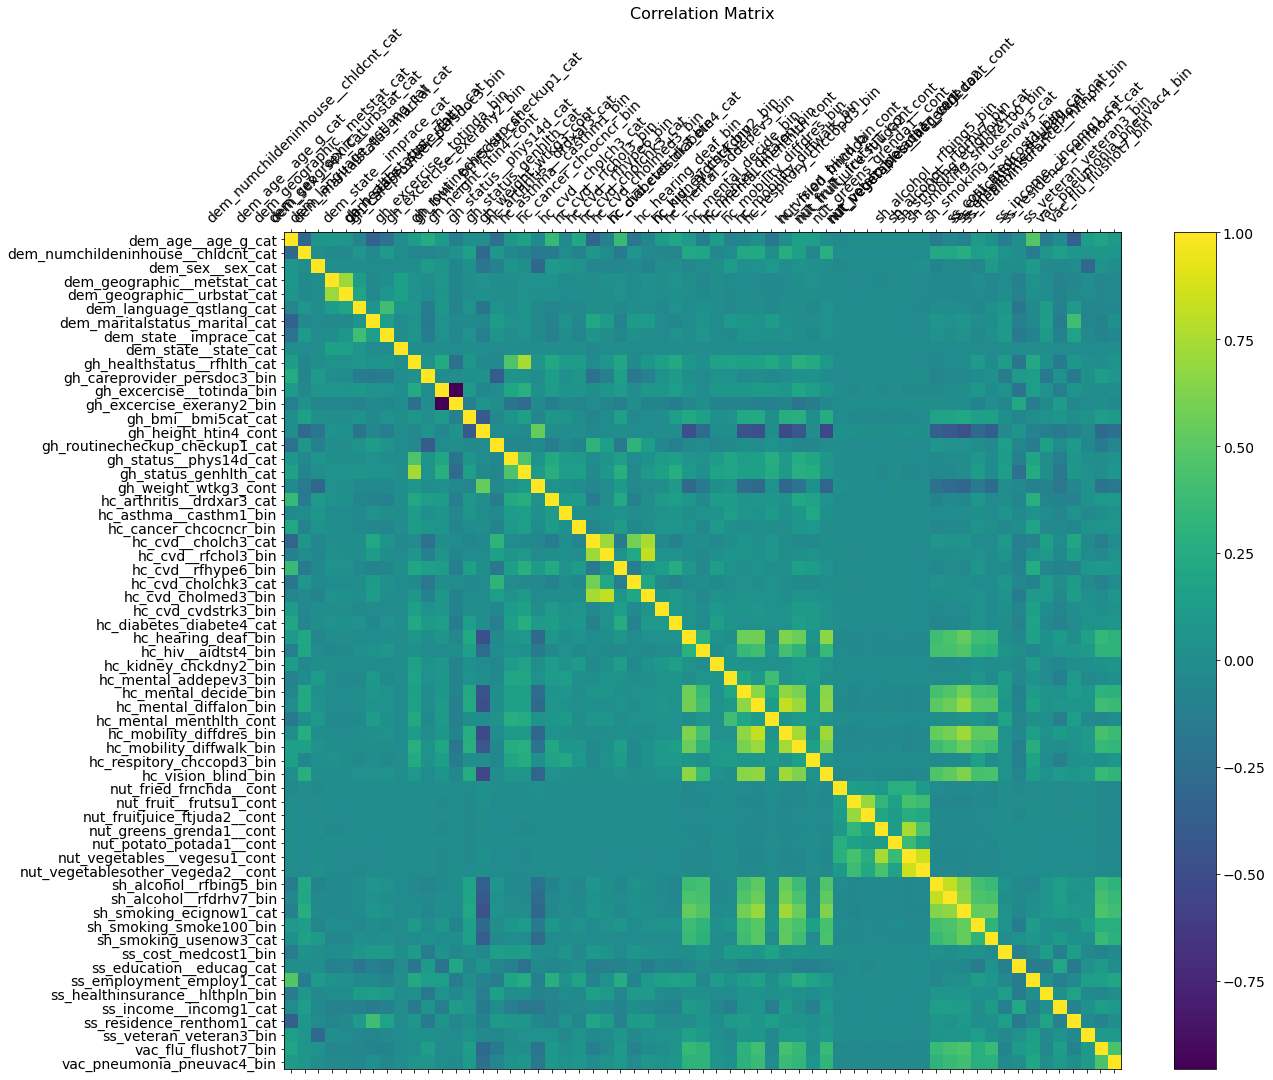

In [70]:
# Plot Correlation Matrix
df=X_train.copy()
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

## Remove Correlated features

In [71]:
corr_features = col_corr 
X_train = X_train.drop(corr_features,axis=1)
X_test = X_test.drop(corr_features,axis=1)
X_train

,dem_age__age_g_cat,dem_numchildeninhouse__chldcnt_cat,dem_sex__sex_cat,dem_geographic__metstat_cat,dem_language_qstlang_cat,dem_maritalstatus_marital_cat,dem_state__imprace_cat,dem_state__state_cat,gh_healthstatus__rfhlth_cat,gh_careprovider_persdoc3_bin,...,sh_smoking_usenow3_cat,ss_cost_medcost1_bin,ss_education__educag_cat,ss_employment_employ1_cat,ss_healthinsurance__hlthpln_bin,ss_income__incomg1_cat,ss_residence_renthom1_cat,ss_veteran_veteran3_bin,vac_flu_flushot7_bin,vac_pneumonia_pneuvac4_bin
401713,5,0,0,1,0,1,0,46,1,1,...,2,2,2,1,0,0,2,1,0,0
51848,4,1,1,0,0,0,0,7,1,1,...,2,0,3,7,0,4,0,0,1,0
30246,0,1,0,0,0,4,4,4,0,0,...,2,0,2,1,1,2,1,0,0,0
255876,2,2,1,0,0,3,1,31,0,1,...,2,1,3,0,0,1,1,0,0,0
41293,3,0,1,0,0,0,0,5,0,1,...,2,0,3,0,0,4,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343403,1,4,1,0,0,0,0,39,0,1,...,2,0,3,5,0,7,0,0,1,2
256395,2,2,0,0,0,4,5,31,0,1,...,2,0,1,0,0,5,0,1,0,0
212916,4,0,0,1,0,2,0,25,0,1,...,0,0,3,6,0,2,0,0,0,0
56620,5,0,0,0,0,1,1,8,1,1,...,2,0,1,7,0,7,1,0,0,0


In [72]:
 X_train = X_train.reset_index(drop=True)

In [73]:
# set max display cols
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
#for col in X_train.columns:
#    print(col, X_train[col].dtype)
X_train

,dem_age__age_g_cat,dem_numchildeninhouse__chldcnt_cat,dem_sex__sex_cat,dem_geographic__metstat_cat,dem_language_qstlang_cat,dem_maritalstatus_marital_cat,dem_state__imprace_cat,dem_state__state_cat,gh_healthstatus__rfhlth_cat,gh_careprovider_persdoc3_bin,gh_excercise__totinda_bin,gh_bmi__bmi5cat_cat,gh_height_htin4_cont,gh_routinecheckup_checkup1_cat,gh_status__phys14d_cat,gh_weight_wtkg3_cont,hc_arthritis__drdxar3_cat,hc_asthma__casthm1_bin,hc_cancer_chcocncr_bin,hc_cvd__cholch3_cat,hc_cvd__rfhype6_bin,hc_cvd_cholchk3_cat,hc_cvd_cvdstrk3_bin,hc_diabetes_diabete4_cat,hc_hearing_deaf_bin,hc_hiv__aidtst4_bin,hc_kidney_chckdny2_bin,hc_mental_addepev3_bin,hc_mental_decide_bin,hc_mental_diffalon_bin,hc_mental_menthlth_cont,hc_respitory_chccopd3_bin,nut_fried_frnchda__cont,nut_fruit__frutsu1_cont,nut_fruitjuice_ftjuda2__cont,nut_greens_grenda1__cont,nut_potato_potada1__cont,sh_alcohol__rfbing5_bin,sh_smoking_smoke100_bin,sh_smoking_usenow3_cat,ss_cost_medcost1_bin,ss_education__educag_cat,ss_employment_employ1_cat,ss_healthinsurance__hlthpln_bin,ss_income__incomg1_cat,ss_residence_renthom1_cat,ss_veteran_veteran3_bin,vac_flu_flushot7_bin,vac_pneumonia_pneuvac4_bin
0,5,0,0,1,0,1,0,46,1,1,0,1,69.0,0,2,6804.0,1,1,0,0,1,1,0,1,1,1,0,1,0,0,28.0,1,0.0,300.0,100.0,50.0,43.0,0,1,2,2,2,1,0,0,2,1,0,0
1,4,1,1,0,0,0,0,7,1,1,0,3,60.0,0,2,7257.0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,14.0,0,10.0,0.0,0.0,7.0,0.0,0,1,2,0,3,7,0,4,0,0,1,0
2,0,1,0,0,0,4,4,4,0,0,0,1,67.0,3,1,6577.0,0,0,0,1,0,6,0,0,0,0,0,0,0,0,25.0,0,20.0,66.0,33.0,10.0,3.0,1,0,2,0,2,1,1,2,1,0,0,0
3,2,2,1,0,0,3,1,31,0,1,1,3,63.0,0,0,10886.0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,14.0,7.0,100.0,3.0,0,0,2,1,3,0,0,1,1,0,0,0
4,3,0,1,0,0,0,0,5,0,1,0,3,67.0,0,0,9979.0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,5.0,1,33.0,200.0,0.0,50.0,33.0,1,1,2,0,3,0,0,4,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303835,1,4,1,0,0,0,0,39,0,1,0,1,67.0,0,0,6577.0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,1.0,0,14.0,314.0,14.0,57.0,3.0,0,0,2,0,3,5,0,7,0,0,1,2
303836,2,2,0,0,0,4,5,31,0,1,0,2,71.0,0,0,9072.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0.0,0,0.0,200.0,100.0,29.0,29.0,0,0,2,0,1,0,0,5,0,1,0,0
303837,4,0,0,1,0,2,0,25,0,1,0,2,72.0,1,0,9752.0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0.0,0,14.0,143.0,100.0,43.0,0.0,0,0,0,0,3,6,0,2,0,0,0,0
303838,5,0,0,0,0,1,1,8,1,1,1,3,68.0,0,2,9344.0,0,0,1,3,1,7,0,1,0,1,0,1,1,0,3.0,0,10.0,0.0,17.0,100.0,20.0,0,1,2,0,1,7,0,7,1,0,0,0


## Perform Chi - Square test

In [74]:
#Reference - https://scikit-learn.org/stable/modules/feature_selection.html
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import chi2

#Calculating Fscore and p value
f_p_values=chi2(X_train,y_train)
f_p_values

(array([1.00166392e+04, 5.52804963e+03, 6.90164511e+02, 2.35621813e+02,
        7.48107433e+01, 1.08676561e+03, 9.17411521e+02, 5.53482815e+01,
        1.20029461e+04, 1.75364661e+02, 2.11175578e+03, 4.05457609e+01,
        8.29052432e+02, 3.40602360e+03, 8.36597605e+03, 8.76581737e+05,
        5.07735432e+03, 6.76261776e+02, 2.55179644e+03, 2.90511657e+03,
        8.02321994e+03, 2.01826683e+03, 1.06381264e+04, 7.14538003e+03,
        2.00313916e+03, 1.80083833e+01, 6.37279996e+03, 4.12773892e+02,
        5.29994948e+02, 1.15514123e+03, 4.39760362e+03, 8.38212749e+03,
        1.41126975e+01, 7.51442481e+02, 2.43374478e+04, 9.46926673e+03,
        4.91875098e+04, 7.36774142e+02, 1.34110841e+03, 1.45970616e+00,
        3.66485504e+01, 6.39845599e+02, 3.34429428e+04, 2.33801371e+02,
        1.53918754e+03, 2.45979272e+02, 2.77417942e+03, 3.77841876e+02,
        1.19177880e+03]),
 array([0.00000000e+000, 0.00000000e+000, 4.11639763e-152, 3.54308684e-053,
        5.18070216e-018, 2.4849648

In [75]:
list(X_train.columns)

['dem_age__age_g_cat',
 'dem_numchildeninhouse__chldcnt_cat',
 'dem_sex__sex_cat',
 'dem_geographic__metstat_cat',
 'dem_language_qstlang_cat',
 'dem_maritalstatus_marital_cat',
 'dem_state__imprace_cat',
 'dem_state__state_cat',
 'gh_healthstatus__rfhlth_cat',
 'gh_careprovider_persdoc3_bin',
 'gh_excercise__totinda_bin',
 'gh_bmi__bmi5cat_cat',
 'gh_height_htin4_cont',
 'gh_routinecheckup_checkup1_cat',
 'gh_status__phys14d_cat',
 'gh_weight_wtkg3_cont',
 'hc_arthritis__drdxar3_cat',
 'hc_asthma__casthm1_bin',
 'hc_cancer_chcocncr_bin',
 'hc_cvd__cholch3_cat',
 'hc_cvd__rfhype6_bin',
 'hc_cvd_cholchk3_cat',
 'hc_cvd_cvdstrk3_bin',
 'hc_diabetes_diabete4_cat',
 'hc_hearing_deaf_bin',
 'hc_hiv__aidtst4_bin',
 'hc_kidney_chckdny2_bin',
 'hc_mental_addepev3_bin',
 'hc_mental_decide_bin',
 'hc_mental_diffalon_bin',
 'hc_mental_menthlth_cont',
 'hc_respitory_chccopd3_bin',
 'nut_fried_frnchda__cont',
 'nut_fruit__frutsu1_cont',
 'nut_fruitjuice_ftjuda2__cont',
 'nut_greens_grenda1__cont',


In [76]:
pvaldf = pd.DataFrame(f_p_values)
pvaldf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,10016.639175,5528.049629,6.901645e+02,2.356218e+02,7.481074e+01,1.086766e+03,9.174115e+02,5.534828e+01,12002.946123,1.753647e+02,2111.755783,4.054576e+01,8.290524e+02,3406.023602,8365.976046,876581.737363,5077.354322,6.762618e+02,2551.796444,2905.116567,8023.219942,2018.266829,10638.126435,7145.380034,2003.139165,18.008383,6372.799962,4.127739e+02,5.299949e+02,1.155141e+03,4397.603625,8382.127487,14.112698,7.514425e+02,24337.447839,9469.266732,49187.509804,7.367741e+02,1.341108e+03,1.459706,3.664855e+01,6.398456e+02,33442.942832,2.338014e+02,1539.187537,2.459793e+02,2774.179417,3.778419e+02,1.191779e+03
1,0.000000,0.000000,4.116398e-152,3.543087e-53,5.180702e-18,2.484965e-238,1.609923e-201,1.009581e-13,0.000000,4.983961e-40,0.000000,1.920648e-10,2.604226e-182,0.000000,0.000000,0.000000,0.000000,4.343742e-149,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000022,0.000000,9.126964e-92,2.831704e-117,3.423865e-253,0.000000,0.000000,0.000172,1.948743e-165,0.000000,0.000000,0.000000,3.014487e-162,1.317933e-293,0.226977,1.414642e-09,3.610105e-141,0.000000,8.838036e-53,0.000000,1.954441e-55,0.000000,3.671319e-84,3.732500e-261


In [77]:
import pandas as pd
p_values=pd.Series(f_p_values[1])
p_values.index=X_train.columns
print(p_values)

chi2_values=pd.Series(f_p_values[0])
chi2_values.index=X_train.columns
print(chi2_values)

dem_age__age_g_cat                     0.000000e+00
dem_numchildeninhouse__chldcnt_cat     0.000000e+00
dem_sex__sex_cat                      4.116398e-152
dem_geographic__metstat_cat            3.543087e-53
dem_language_qstlang_cat               5.180702e-18
dem_maritalstatus_marital_cat         2.484965e-238
dem_state__imprace_cat                1.609923e-201
dem_state__state_cat                   1.009581e-13
gh_healthstatus__rfhlth_cat            0.000000e+00
gh_careprovider_persdoc3_bin           4.983961e-40
gh_excercise__totinda_bin              0.000000e+00
gh_bmi__bmi5cat_cat                    1.920648e-10
gh_height_htin4_cont                  2.604226e-182
gh_routinecheckup_checkup1_cat         0.000000e+00
gh_status__phys14d_cat                 0.000000e+00
gh_weight_wtkg3_cont                   0.000000e+00
hc_arthritis__drdxar3_cat              0.000000e+00
hc_asthma__casthm1_bin                4.343742e-149
hc_cancer_chcocncr_bin                 0.000000e+00
hc_cvd__chol

In [78]:
print('pvalue<.05',p_values[p_values < 0.05])

pvalue<.05 dem_age__age_g_cat                     0.000000e+00
dem_numchildeninhouse__chldcnt_cat     0.000000e+00
dem_sex__sex_cat                      4.116398e-152
dem_geographic__metstat_cat            3.543087e-53
dem_language_qstlang_cat               5.180702e-18
dem_maritalstatus_marital_cat         2.484965e-238
dem_state__imprace_cat                1.609923e-201
dem_state__state_cat                   1.009581e-13
gh_healthstatus__rfhlth_cat            0.000000e+00
gh_careprovider_persdoc3_bin           4.983961e-40
gh_excercise__totinda_bin              0.000000e+00
gh_bmi__bmi5cat_cat                    1.920648e-10
gh_height_htin4_cont                  2.604226e-182
gh_routinecheckup_checkup1_cat         0.000000e+00
gh_status__phys14d_cat                 0.000000e+00
gh_weight_wtkg3_cont                   0.000000e+00
hc_arthritis__drdxar3_cat              0.000000e+00
hc_asthma__casthm1_bin                4.343742e-149
hc_cancer_chcocncr_bin                 0.000000e+00
h

In [79]:
print('num vars<.05=',len(p_values[p_values < 0.05]))

num vars<.05= 48


## Mutual information gain

In [80]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([0.04335526, 0.00954367, 0.02066746, 0.00595584, 0.00056767,
       0.01732381, 0.00466914, 0.002889  , 0.02048978, 0.05226216,
       0.00696915, 0.0164997 , 0.00508438, 0.00684809, 0.01488802,
       0.00394162, 0.01803579, 0.00170463, 0.00424804, 0.00626006,
       0.03061935, 0.02583257, 0.01151389, 0.01303316, 0.00714484,
       0.00820885, 0.00636531, 0.00308291, 0.00256363, 0.00493741,
       0.00223794, 0.0101158 , 0.00252936, 0.00174834, 0.00249129,
       0.00310621, 0.00359556, 0.00444884, 0.01426494, 0.05382902,
       0.00065324, 0.02326456, 0.03385081, 0.00157749, 0.0159276 ,
       0.00490648, 0.00522858, 0.01643651, 0.0228427 ])

## Representing in list form

In [81]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info#.sort_values(ascending=False)
print(mutual_info)

dem_age__age_g_cat                    0.043355
dem_numchildeninhouse__chldcnt_cat    0.009544
dem_sex__sex_cat                      0.020667
dem_geographic__metstat_cat           0.005956
dem_language_qstlang_cat              0.000568
dem_maritalstatus_marital_cat         0.017324
dem_state__imprace_cat                0.004669
dem_state__state_cat                  0.002889
gh_healthstatus__rfhlth_cat           0.020490
gh_careprovider_persdoc3_bin          0.052262
gh_excercise__totinda_bin             0.006969
gh_bmi__bmi5cat_cat                   0.016500
gh_height_htin4_cont                  0.005084
gh_routinecheckup_checkup1_cat        0.006848
gh_status__phys14d_cat                0.014888
gh_weight_wtkg3_cont                  0.003942
hc_arthritis__drdxar3_cat             0.018036
hc_asthma__casthm1_bin                0.001705
hc_cancer_chcocncr_bin                0.004248
hc_cvd__cholch3_cat                   0.006260
hc_cvd__rfhype6_bin                   0.030619
hc_cvd_cholch

## Select best features

## Top 25

In [82]:
from sklearn.feature_selection import SelectKBest
#Now we Will select the top k important features
sel_k_cols = SelectKBest(mutual_info_classif, k=25)
sel_k_cols.fit(X_train, y_train)
top25=X_train.columns[sel_k_cols.get_support()]

In [83]:
display(pd.DataFrame(top25))

,0
0,dem_age__age_g_cat
1,dem_numchildeninhouse__chldcnt_cat
2,dem_sex__sex_cat
3,dem_maritalstatus_marital_cat
4,gh_healthstatus__rfhlth_cat
5,gh_careprovider_persdoc3_bin
6,gh_excercise__totinda_bin
7,gh_bmi__bmi5cat_cat
8,gh_status__phys14d_cat
9,hc_arthritis__drdxar3_cat


In [84]:
from sklearn.linear_model import LogisticRegression
model1=LogisticRegression()
model1.fit(X_train,y_train)

C:\Users\timbr\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [85]:
from sklearn.metrics import accuracy_score, confusion_matrix
predictions= model1.predict(X_test)
percentage= model1.score(X_test,y_test)
res=confusion_matrix(y_test,predictions)
print("confusion matrix")
print(res)
# check the accuracy on the training set
print(model1.score(X_train, y_train))
print(model1.score(X_test, y_test))
print(f"Test set:{len(X_test)}")
print(f"Accuracy={percentage*100}%")

confusion matrix
[[119568     16]
 [ 10631      3]]
0.9186743022643497
0.9182371100769479
Test set:130218
Accuracy=91.82371100769478%


In [86]:
#remove where coef are close to zero
coef = model1.coef_[0]
imp_features = pd.Series(X_train.columns)[list(coef!=0)]
X_train = X_train[imp_features]
X_test = X_test[imp_features]
len(imp_features)


49

## Top 10

In [87]:
# select top 10 attribs and run logistic regression with them
from sklearn.feature_selection import SelectKBest
#Now we Will select the top k important features
sel_k_cols = SelectKBest(mutual_info_classif, k=10)
sel_k_cols.fit(X_train, y_train)
top10Cols=X_train.columns[sel_k_cols.get_support()]

In [88]:
display(pd.DataFrame(top10Cols))

,0
0,dem_age__age_g_cat
1,dem_sex__sex_cat
2,gh_healthstatus__rfhlth_cat
3,gh_careprovider_persdoc3_bin
4,hc_cvd__rfhype6_bin
5,hc_cvd_cholchk3_cat
6,sh_smoking_usenow3_cat
7,ss_education__educag_cat
8,ss_employment_employ1_cat
9,vac_pneumonia_pneuvac4_bin


In [89]:
X_train=X_train[top10Cols]
X_test=X_test[top10Cols]

In [90]:
from sklearn.linear_model import LogisticRegression
model2=LogisticRegression()
model2.fit(X_train,y_train)

LogisticRegression()

In [91]:
from sklearn.metrics import accuracy_score, confusion_matrix
predictions= model2.predict(X_test)
percentage= model2.score(X_test,y_test)
res=confusion_matrix(y_test,predictions)
print("confusion matrix")
print(res)
# check the accuracy on the training set
# print(model2.score(X_train, y_train))
print(model2.score(X_test, y_test))
print(f"Test set:{len(X_test)}")
print(f"Accuracy={percentage*100}%")

confusion matrix
[[119262    322]
 [ 10429    205]]
0.9174384493695188
Test set:130218
Accuracy=91.74384493695187%


In [92]:
coef = model2.coef_[0]
print(model2.feature_names_in_)
print(model2.coef_)
dfcoef = pd.DataFrame(model2.coef_)
display(dfcoef)
# X_train

['dem_age__age_g_cat' 'dem_sex__sex_cat' 'gh_healthstatus__rfhlth_cat'
 'gh_careprovider_persdoc3_bin' 'hc_cvd__rfhype6_bin'
 'hc_cvd_cholchk3_cat' 'sh_smoking_usenow3_cat' 'ss_education__educag_cat'
 'ss_employment_employ1_cat' 'vac_pneumonia_pneuvac4_bin']
[[ 0.50179563 -0.68796775  1.07912478  0.25438275  0.80344988 -0.07693121
  -0.13753392 -0.11380556  0.08218157  0.15262345]]


,0,1,2,3,4,5,6,7,8,9
0,0.501796,-0.687968,1.079125,0.254383,0.80345,-0.076931,-0.137534,-0.113806,0.082182,0.152623


In [93]:
for col in top10Cols:
    print(col)

dem_age__age_g_cat
dem_sex__sex_cat
gh_healthstatus__rfhlth_cat
gh_careprovider_persdoc3_bin
hc_cvd__rfhype6_bin
hc_cvd_cholchk3_cat
sh_smoking_usenow3_cat
ss_education__educag_cat
ss_employment_employ1_cat
vac_pneumonia_pneuvac4_bin


In [94]:
#store the model in using pickle in file
import pickle
filename = 'model\model_chd_prediction.sav'
pickle.dump(model2, open(filename, 'wb'))

In [95]:
# load the model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9174384493695188


In [96]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
regression_results(y_test,predictions)

explained_variance:  -0.0206
mean_squared_log_error:  0.0397
r2:  -0.1009
MAE:  0.0826
MSE:  0.0826
RMSE:  0.2873


## Single Var Predictor

In [97]:
var = 'dem_sex__sex_cat'

X_train_var = X_train_full[var]
X_test_var = X_test_full[var]
print('Unique Vals:',X_train_full[var].unique())
X_train_var= X_train_var.to_numpy().reshape(-1, 1)
X_test_var= X_test_var.to_numpy().reshape(-1, 1)
print(X_train_var.shape)
print(X_test_var.shape)

Unique Vals: [0 1]
(303840, 1)
(130218, 1)


In [98]:
from sklearn.linear_model import LogisticRegression
modelvar=LogisticRegression()
modelvar.fit(X_train_var,y_train)

LogisticRegression()

In [99]:
coef = modelvar.coef_[0]
import math
print('Coef',coef[0])
print('Log Odds',math.exp(dfcoef[0]))

Coef -0.5143007354847025
Log Odds 1.6516844222292082


In [100]:
from sklearn.metrics import accuracy_score, confusion_matrix
predictions= modelvar.predict(X_test_var)
percentage= modelvar.score(X_test_var,y_test)
res=confusion_matrix(y_test,predictions)
print("confusion matrix")
print(res)
# check the accuracy on the training set
# print(model2.score(X_train, y_train))
print(modelvar.score(X_test_var, y_test))
print(f"Test set:{len(X_test_var)}")
print(f"Accuracy={percentage*100}%")

confusion matrix
[[119584      0]
 [ 10634      0]]
0.9183369426653766
Test set:130218
Accuracy=91.83369426653766%


In [101]:
dfnew = pd.DataFrame([[1]], columns=[var])
# predictions= modelage.predict(dfnew)
modelvar.predict_proba(dfnew)

C:\Users\timbr\Anaconda3\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([[0.93652222, 0.06347778]])